In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import tensorflow as tf 
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OneHotEncoder
import tensorflow.keras as keras
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

from sklearn.metrics import roc_curve, auc, confusion_matrix,accuracy_score,precision_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
review_df = pd.read_pickle('food_review_places.pickle')

In [ ]:
review_df['rating'].value_counts()

5.0    34487
4.0    19041
3.0     8118
2.0     5010
1.0     3539
Name: rating, dtype: int64

In [ ]:
review_df

,gPlusPlaceId,rating,reviewerName,reviewText,categories,unixReviewTime,reviewTime,gPlusUserId,name,price,address,hours,phone,closed,gps,lat,long,open_days,Dinner,Lunch,Breakfast
0,112181651134020562716,5.0,jason wagner,stop dinner mahi mahi special fantast servic g...,"[european restaurant, italian restaurant]",2012-10-18 21:56:05,2012-10-18,100000196778399872657,Pasquales Trattoria,None,"[50 Lakeshore Rd W, Oakville, ON L6Y 2K3, Canada]","[[Monday, [['Closed']]], [Tuesday, [['11:30 am...",(905) 338-9090,False,"[43.440331, -79.672851]",43.440331,-79.672851,6.0,1.0,0.0,0.0
1,109391653021436219474,5.0,heather goldsworthy,best coffe collingwood,[cafe],2013-09-12 18:38:15,2013-09-12,100000427343266187570,Espresso Post,None,"[139 Hurontario St, Collingwood, ON L9Y, Canada]",None,(705) 446-1740,False,"[44.499252, -80.216587]",44.499252,-80.216587,NaN,NaN,NaN,NaN
2,109391653021436219474,5.0,nicholas clayton,locat old post offic outlet histor pedigre bes...,[cafe],2013-05-04 01:35:12,2013-05-03,104975196938413074237,Espresso Post,None,"[139 Hurontario St, Collingwood, ON L9Y, Canada]",None,(705) 446-1740,False,"[44.499252, -80.216587]",44.499252,-80.216587,NaN,NaN,NaN,NaN
3,110864889964667973890,5.0,chris johnson,get right everi time love guy,"[delivery restaurant, event planner, business ...",2011-09-15 21:54:03,2011-09-15,100000524810171549476,"Delivered Dish | Portland, OR",$$,"[Portland, OR]","[[Monday, [['8:00 am--9:00 pm']]], [Tuesday, [...",(503) 239-0100,False,"[45.470342, -122.747085]",45.470342,-122.747085,7.0,1.0,0.0,0.0
4,110864889964667973890,1.0,allison lea,use servic order even show 1 hour 20 minut pro...,"[delivery restaurant, event planner, business ...",2013-11-09 10:28:01,2013-11-08,100537426867747151661,"Delivered Dish | Portland, OR",$$,"[Portland, OR]","[[Monday, [['8:00 am--9:00 pm']]], [Tuesday, [...",(503) 239-0100,False,"[45.470342, -122.747085]",45.470342,-122.747085,7.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70190,113840395279665001642,5.0,ture jackson,great,[cafe],2012-06-10 03:18:34,2012-06-09,106224892970344797880,Second Cup,None,"[6550 200 St, Langley, BC V2Y 1P2, Canada]","[[Monday, [['8:00 am--9:00 pm']]], [Tuesday, [...",(604) 514-5085,True,"[49.121205, -122.668297]",49.121205,-122.668297,7.0,1.0,0.0,1.0
70191,108887431842899649801,4.0,tomasz w,surprisingli good mere 14 buck get larg pizza ...,[delivery restaurant],2013-11-16 05:42:46,2013-11-15,106224899821829244630,Little Caesars Pizza,$$$,"[12830 96 Ave, Surrey, BC V3V 6A8, Canada]","[[Monday, [['11:00 am--11:00 pm']]], [Tuesday,...",(604) 584-0090,False,"[49.176368, -122.867572]",49.176368,-122.867572,7.0,1.0,1.0,0.0
70192,112463911517644715471,2.0,adrian ludwin,busi march 2013,"[cafe, dessert shop, ice cream shop]",2013-03-08 18:03:34,2013-03-08,106225840000504273299,Baskin-Robbins Ice Cream,$$,"[1976 Queen St E, Toronto, ON M4L, Canada]",None,(416) 698-3103,True,"[43.669867, -79.301196]",43.669867,-79.301196,NaN,NaN,NaN,NaN
70193,105703129044638346837,4.0,timothy decker,great food tim owner btw differ tim lol work h...,[bar],2013-08-15 05:50:22,2013-08-14,106226813159080833866,Rainbow Bar,None,"[905 W Main St, Owosso, MI 48867]","[[Monday, [['7:00 am--4:00 am']]], [Tuesday, [...",(989) 725-9880,False,"[42.997547, -84.182386]",42.997547,-84.182386,7.0,1.0,1.0,1.0


In [ ]:
enc = OneHotEncoder()
reviews = list(review_df['reviewText'])
ratings = np.array(list(review_df['rating']))
# one-hot encode the ratings
ratings = enc.fit_transform(ratings.reshape(-1, 1)).toarray()

In [ ]:
split = 0.8
train_len = int(split * len(reviews))
train_reviews = np.array(reviews[:train_len])
train_ratings = np.array(ratings[:train_len])
test_reviews = np.array(reviews[train_len:])
test_ratings = np.array(ratings[train_len:])

In [ ]:
max_size = 1000
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_size, output_mode='int', output_sequence_length=20)
vectorize_layer.adapt(train_reviews)

In [ ]:
inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string, name='text')
outputs = vectorize_layer(inputs)
model = tf.keras.Model(inputs, outputs)
# vocab = np.array(vectorize_layer.get_vocabulary())

In [ ]:
encoded_train_reviews = model.predict(train_reviews)
encoded_test_reviews = model.predict(test_reviews)

In [ ]:
inputs = tf.keras.Input(shape=(20,), dtype="int64")
x = layers.Embedding(input_dim=1001, output_dim=256,)(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Conv1D(32, 2, padding="valid", activation="relu", strides=1)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(5, activation="softmax", name="predictions")(x)
model = tf.keras.Model(inputs, predictions)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()
history = model.fit(encoded_train_reviews, train_ratings, validation_split=0.2, epochs=10)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 256)           256256    
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 19, 32)            16416     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

In [ ]:
score, acc = model.evaluate(encoded_test_reviews, test_ratings)

439/439 [==============================] - 1s 3ms/step - loss: 1.1070 - accuracy: 0.5525


In [ ]:
prob_test = np.round(model.predict(encoded_test_reviews))
prob_test = pd.DataFrame(data = prob_test, columns = ['1', '2', '3','4','5'])
prob_test = prob_test.idxmax(axis = 1)

test_ratings_df = pd.DataFrame(data = test_ratings, columns = ['1', '2', '3','4','5'])
y_test_label = test_ratings_df.idxmax(axis = 1)

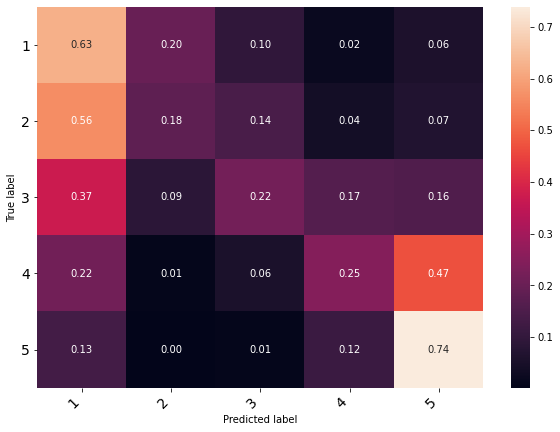

In [ ]:

# Calculate confusion matrix
confusion_matrix_dnn = confusion_matrix(y_true = y_test_label, 
                    y_pred = prob_test)

# Turn matrix to percentages
confusion_matrix_dnn = confusion_matrix_dnn.astype('float') / confusion_matrix_dnn.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_dnn, index=['1', '2', '3','4','5'],
         columns=['1', '2', '3','4','5'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

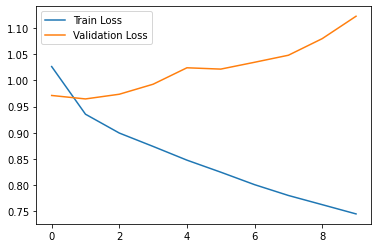

In [ ]:
plt.plot(history.history['loss'],label = "Train Loss")
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
accuracy_score(y_test_label,prob_test)*100

49.747132986679965

In [ ]:
prob_train = np.round(model.predict(encoded_train_reviews))
prob_train = pd.DataFrame(data = prob_train, columns = ['1', '2', '3','4','5'])
prob_train = prob_train.idxmax(axis = 1)

train_ratings_df = pd.DataFrame(data = train_ratings, columns = ['1', '2', '3','4','5'])
y_train_label = train_ratings_df.idxmax(axis = 1)

In [ ]:
accuracy_score(y_train_label,prob_train)*100

62.39938742075647